In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv("../DATA/RSCCASN.csv",parse_dates=True,index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [20]:
df.columns=['Sales']

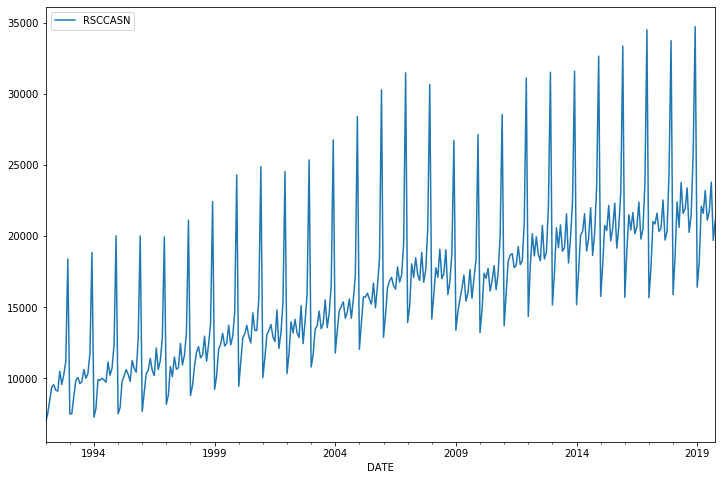

In [10]:
df.plot(figsize=(12,8))

In [21]:
len(df)

334

In [22]:
test_size = 20

In [23]:
test_ind = len(df)-test_size

In [35]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [25]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-10-01,20307
2017-11-01,24438
2017-12-01,33720


In [27]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
sc = MinMaxScaler()

In [37]:
scaled_train = sc.fit_transform(train)

In [38]:
scaled_test = sc.transform(test)

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
length =12
gen = TimeseriesGenerator(scaled_train,scaled_train,length = length,batch_size=1)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [45]:
n_features = 1

In [47]:

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [51]:
valid_gen = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [52]:
model.fit_generator(gen,epochs=20,
                    validation_data=valid_gen,
                   callbacks=[early_stop])

/Users/shashidhar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
302/302 [==============================] - 6s 11ms/step - loss: 0.0251 - val_loss: 0.0079
Epoch 2/20
302/302 [==============================] - 3s 9ms/step - loss: 0.0171 - val_loss: 0.0021
Epoch 3/20
302/302 [==============================] - 3s 9ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 4/20
302/302 [==============================] - 2s 8ms/step - loss: 0.0043 - val_loss: 0.0163


In [53]:
losses = pd.DataFrame(model.history.history)

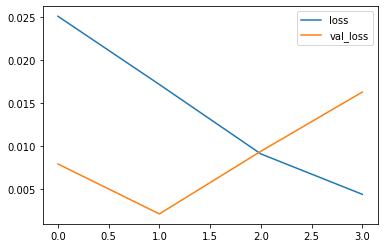

In [54]:
losses.plot()

In [55]:
first_eval_batch = scaled_train[-length:]

In [57]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [58]:
model.predict(first_eval_batch)

array([[0.59862417]], dtype=float32)

In [59]:
scaled_test[0]

array([0.5615016])

In [60]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    
    current_pred = model.predict(current_batch)[0]
    

    test_predictions.append(current_pred) 
    

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [62]:
true_predictions = sc.inverse_transform(test_predictions)

In [63]:
test['Predictions'] = true_predictions

/Users/shashidhar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
test

,Sales,Predictions
DATE,,
2018-03-01,22404,23426.504134
2018-04-01,20616,23457.810671
2018-05-01,23764,24328.163269
2018-06-01,21589,23245.714587
2018-07-01,21919,23686.870961
2018-08-01,23381,25748.362680
2018-09-01,20260,23121.704975
2018-10-01,21473,24116.650006
2018-11-01,25831,28727.934320


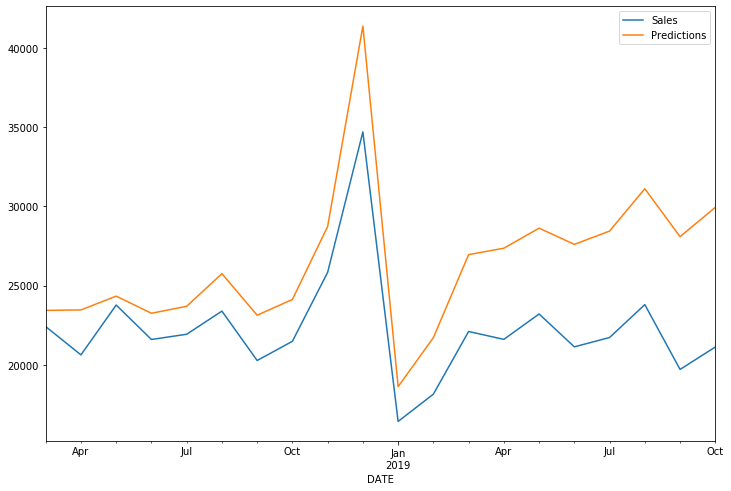

In [66]:
test.plot(figsize=(12,8))

## FORECASTING

In [67]:
fsc = MinMaxScaler()
scaled_full_data = fsc.fit_transform(df)

In [68]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [69]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit(gen,epochs=8)

Epoch 1/8
302/302 [==============================] - 4s 8ms/step - loss: 0.0235
Epoch 2/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0189
Epoch 3/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0117
Epoch 4/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0062
Epoch 5/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0022
Epoch 6/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 7/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0020
Epoch 8/8
302/302 [==============================] - 2s 8ms/step - loss: 0.0015


In [70]:
forecast = []
# periods should be equal to length specified above
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
forecast = sc.inverse_transform(forecast)

In [72]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [73]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [74]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [75]:
forecast_df

,Forecast
2019-11-01,25250.669349
2019-12-01,34886.934437
2020-01-01,16644.225816
2020-02-01,18090.889421
2020-03-01,21259.838605
2020-04-01,20931.695398
2020-05-01,22390.584298
2020-06-01,20575.110509
2020-07-01,21145.851879
2020-08-01,23027.356867


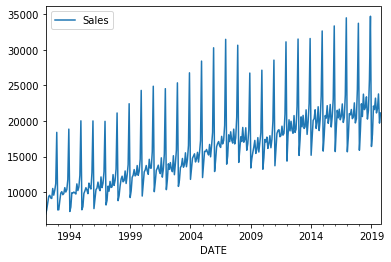

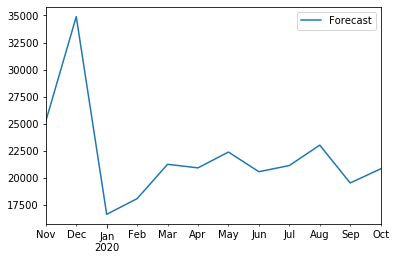

In [76]:
df.plot()
forecast_df.plot()

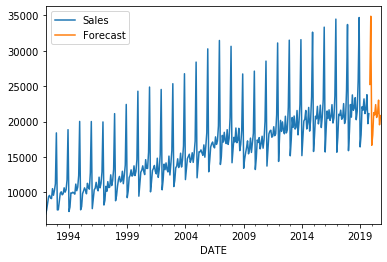

In [77]:
ax = df.plot()
forecast_df.plot(ax=ax)# for joining in same plot